**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends) - **this notebook**
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people)
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences) 
* [Part 7: Survival analysis](https://www.kaggle.com/konradb/ts-7-survival-analysis)
* [Part 8: Hierarchical time series](https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) - **based on this notebook**
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg) 
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E)  
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs)
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk)
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8]()


---------------------------------------


The notebook is split into three sections: we introduce the basic framework of linear processes, then present extensions and finally demonstrate how to solve a prediction problem from scratch. 

* [Basic linear processes](#section-one)
* [Beyond ARMA](#section-two)
* [Full pipeline](#section-three)
* [A day at the races](#section-four)

As usual, we begin by importing the required packages

In [1]:
# It's a Surprise Tool That Will Help Us Later ;-)
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 291 kB/s 


In [2]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

import os
from IPython.display import Image

import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

from fbprophet import Prophet 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

warnings.simplefilter(action='ignore', category= FutureWarning)

In [3]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

<a id="section-one"></a>
# Basic linear processes

Until 1980s, ARIMA processes were the workhorses of time series analysis, which for many people meant just finding right order of such model. This class of processes is defined through linear relationship between observation and noise factors.

Just to indulge my inner nerd, I will go top-down in this one and start from a high level definition - because why not :-) A linear process is a time series $X_t$ defined by:

\begin{equation}
    X_t = \sum_{u = -\infty}^{\infty} \psi_u \epsilon_{t-u}
\end{equation}

where $\epsilon_t$ is a white noise series and 

\begin{equation}
\sum_{u = -\infty}^{\infty} \left|\psi_u \right|^2 < \infty
\end{equation}


Translated to plain English:
* (in our context) white noise a serially uncorrelated sequence of random variables with zero mean and finite variance. For a general definition (and the origin of the color convention) I can recommend the Wikipedia entry: https://en.wikipedia.org/wiki/White_noise

* it is a linear combination - potentially infinite and depending on both past and present - of a white noise series

* in the real world it has to be causal $\implies$ depending on a finite number of past values

* it is a unified framework for handling different types of data generating processes

* for the mathematically inclided person reading this: huge parts of the theory behind ARMA processes pop up as special cases / corrolaries from results in functional analysis, specifically the [Hilbert projection theorem](https://en.wikipedia.org/wiki/Hilbert_projection_theorem) and [spectral theorem](https://en.wikipedia.org/wiki/Spectral_theorem); the requirement on sum of squared values being finite correspond to belonging to an $l_2$ space for our sequence: https://en.wikipedia.org/wiki/Lp_space

* only needs second order statistics (variance) $\rightarrow$ works best for elliptical distributions (e.g. Gaussian)



## AR processes

The simplest (non-trivial) example of a linear process is an autoregressive process of order $p$:

\begin{equation}
    X_t = \sum_{i= 1}^p \phi_i X_{t-i} + \epsilon_t
\end{equation}
    
Unpacking the formula:
1. Natural extension of a multiple linear regression model: we forecast the variable of interest using a linear combination of past values of the variable (lagged values act as predictors). The term \textit{auto}regression reflects the fact that we are regressing the variable on (version of) itself
2. The single exponential smoothing method (described [here](https://www.kaggle.com/konradb/ts-1a-smoothing-methods) ) can be viewed as a special case of an autoregressive process of order 1
3. Easy to estimate parameters and forecast 


Now that we have defined (and hopefully understood) what an AR process is, let's have a look at how to identify one. This is relevant if we need to decide whether an autoregressive process is a right kind of model for a particular dataset. For the sake of demonstration, we will use simulated data, where the data generating process is:

\begin{equation}
    X_t = 0.9 X_{t-1} + \epsilon_t
\end{equation}
    
Observe in the codeblock below that the coefficient changes sign - this is because of the notational convention in statsmodels, where we read the coefficients in order defined by the characteristic polynomial (more on that below):

\begin{equation}
    X_t - 0.9 X_{t-1} = \epsilon_t
\end{equation}


A fast technique for deciding if AR is the right kind of model for a given series is to examine the autocorrelation and partial autocorrelation functions (described [here](https://www.kaggle.com/konradb/practical-time-series-pt-1-the-basics#Dependence)). 

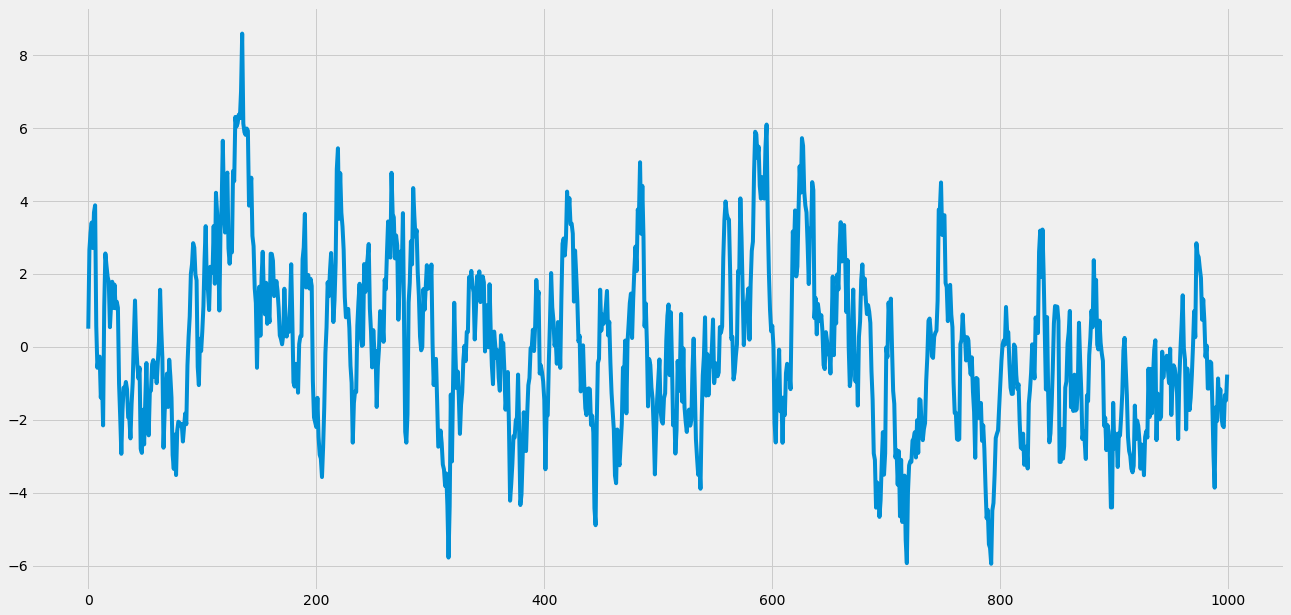

In [4]:
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

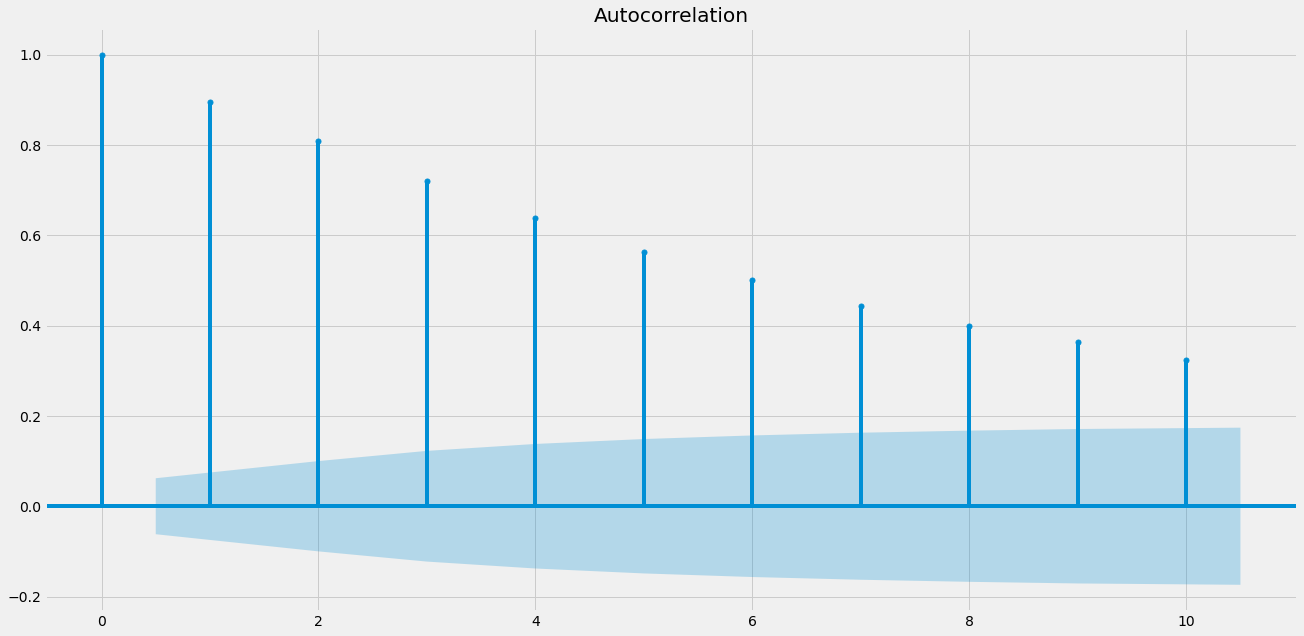

In [5]:
plot_acf(simulated_data_1, lags = 10)
plt.show()

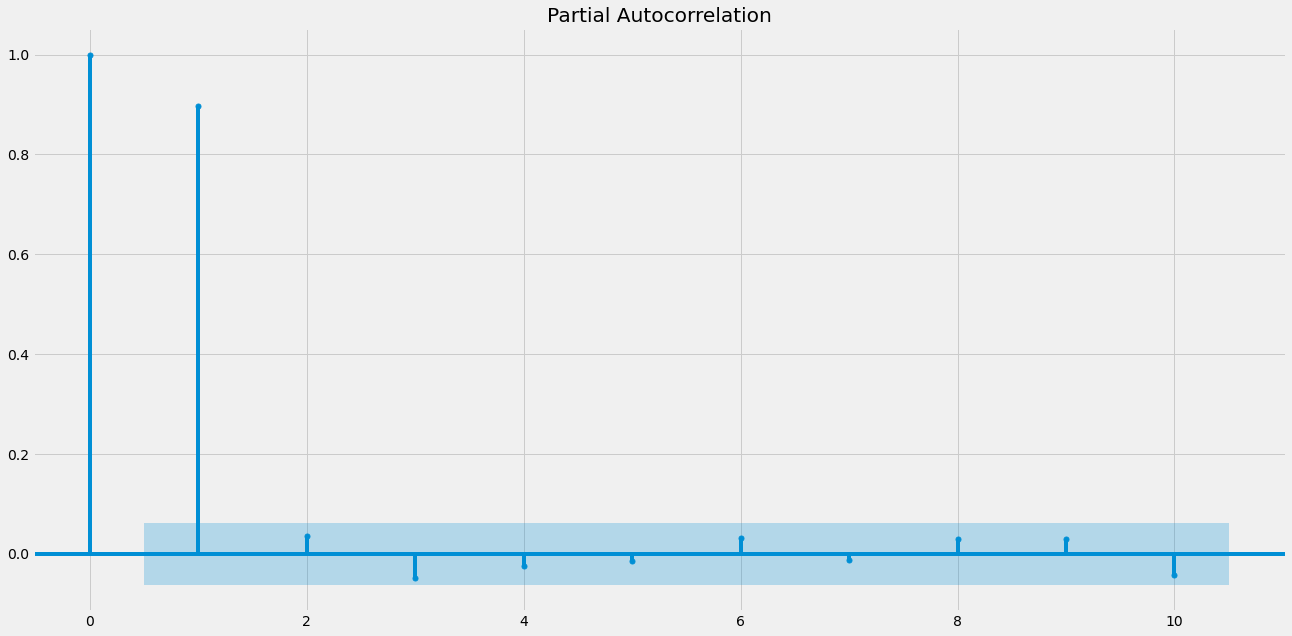

In [6]:
plot_pacf(simulated_data_1, lags = 10)
plt.show()

Intuition for identification:
* process memory: direct and indirect dependence information
* ACF for AR(p): strong until lag p, trailing off afterwards
* PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.
* analytical derivation is based on the Laurent series expansion and the backshift operator $B$


## MA processes

An autoregressive model expresses the forecast variable as a linear combination of past realizations of itself and the same idea can be applied to past forecast errors: a moving average process of order $q$ is defined by the relationship:
    
\begin{equation}
X_t = \epsilon_t + \sum_{i = 1}^q \theta_i \epsilon_{t-i}
\end{equation}

where $\epsilon_t$ is a white noise series.
  
Let's repeat the identification exercise from before:

\begin{equation}
    X_t = \epsilon_t + 0.9  \epsilon_{t-1}
\end{equation}


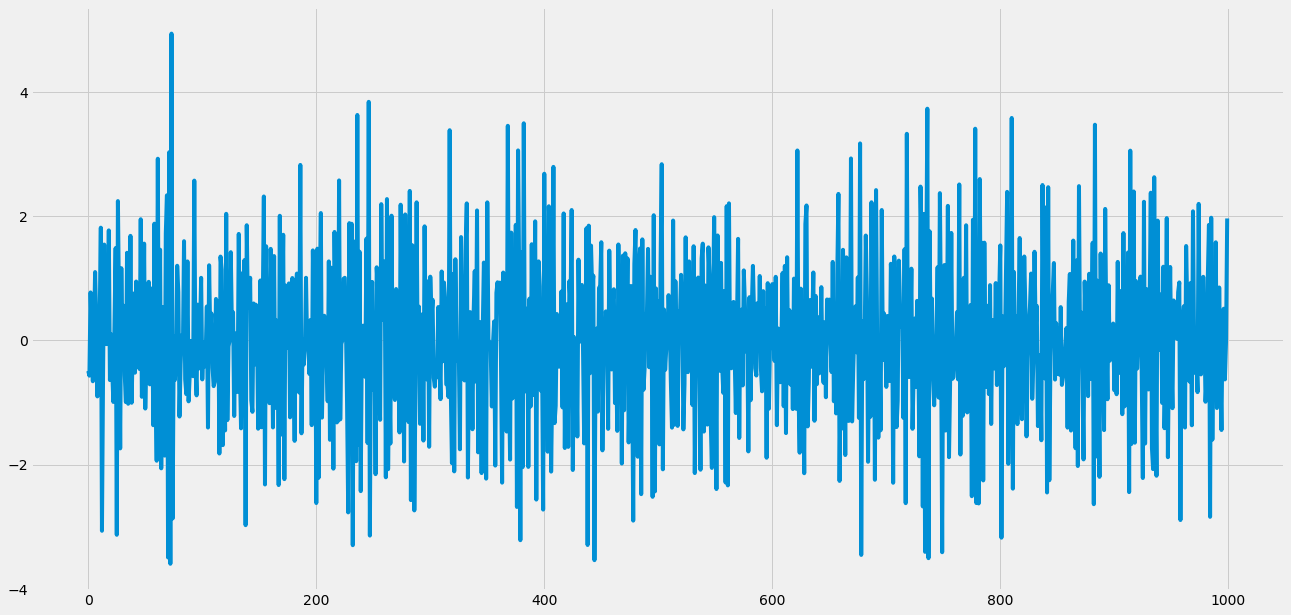

In [7]:
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

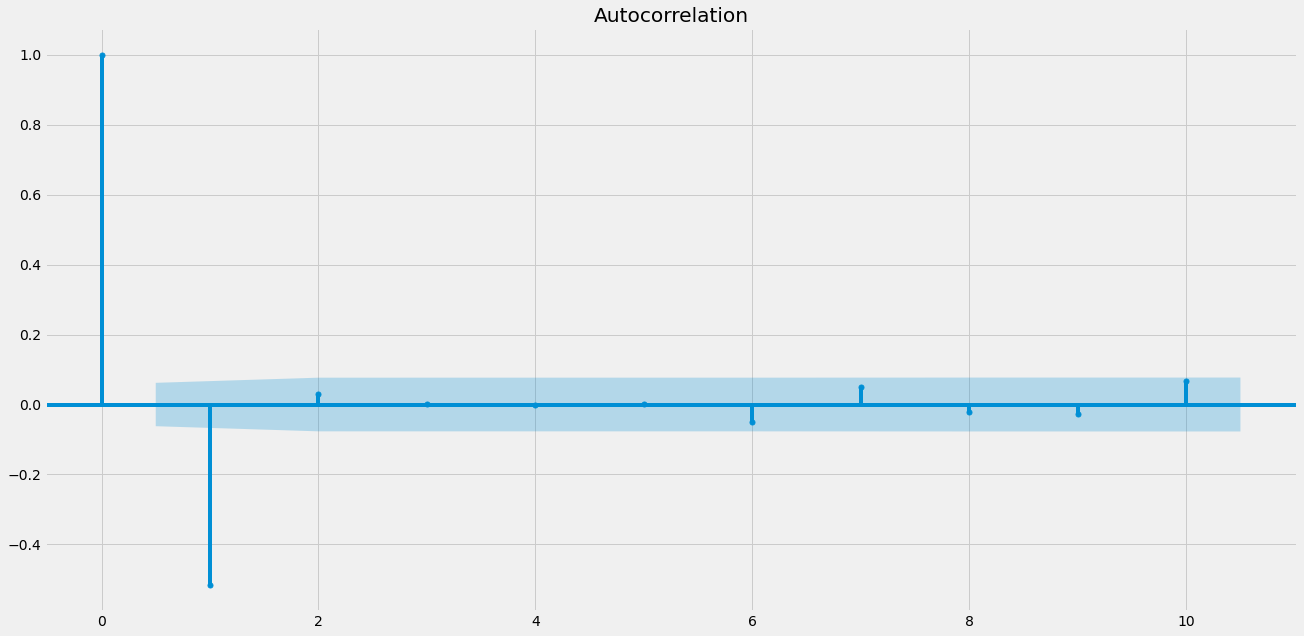

In [8]:
plot_acf(simulated_data_1, lags = 10)
plt.show()

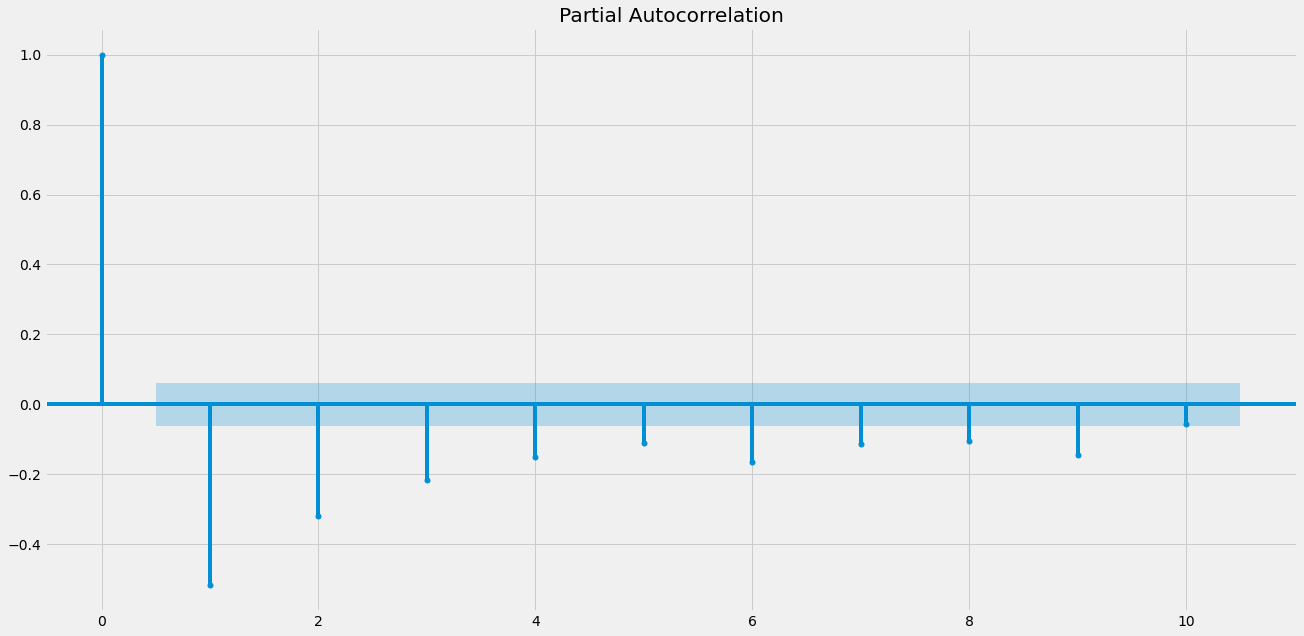

In [9]:
plot_pacf(simulated_data_1, lags = 10)
plt.show()

Intuition for identification:
* MA model corrects future forecasts based on errors made on recent forecasts.
* ACF for MA(k) series: to show a strong correlation with recent values up to the lag of k, then a sharp decline 
* PACF: strong relationship to the lag k and a trailing off of correlation from the lag onwards.

## ARMA

We have an autoregressive component and a moving average one, so it is quite natural to combine those two types of dynamics into a single model: ARMA(p,q) series satisfies the relationship:

\begin{equation}
X_t = \sum_{i=1}^p \phi_i X_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t
\end{equation}

where our predictors on the right hand side include both lagged values of the series and lagged errors, $p$ is the order the autoregressive part and $q$ is the order of the moving average component.

Some observations:
1. if an ARMA(p,q) model is stationary (see [this one](https://www.kaggle.com/konradb/ts-0-the-basics#Stationarity) for a refresher), it can be represented as an infinite AR series

\begin{equation}    
    X_t = \sum_{u=1}^\infty \pi_u X_{t-u} + \epsilon_t
\end{equation}

2. this allows for estimation via maximum likelihood and a simple recursive forecast:

\begin{equation}
    \hat{X}_{T+1} = \sum_{u=1}^\infty \hat{\pi}_u X_{T+1 - u}
\end{equation}

In practice: Kalman filter.

3. Stationarity of the ARMA(p,q) process is established by analyzing the characteristic polynomial. There is quite a substantial body of theory behind this idea, but we are focusing on practical applications here - so a crash-course argument would go like this:

    * given ARMA(p,q) series defined by the equation above, we can write its characteristic polynomial 
    
    \begin{equation}
    P(z) = 1 - \phi_1 z - \ldots - \phi_p z^p
    \end{equation}
    
    * if we look for solutions in complex (as opposed to real numbers) domain, the equation P(z) = 0 has $p$ solutions $z_1, \ldots, z_p$ (corollary from the Fundamental Theorem of Algebra: https://en.wikipedia.org/wiki/Fundamental_theorem_of_algebra)
       
    * if $|z_i| >1$ for all $i$ then the underlying model is stationary
    * tests like Augmented Dickey-Fuller check for this behavior
    

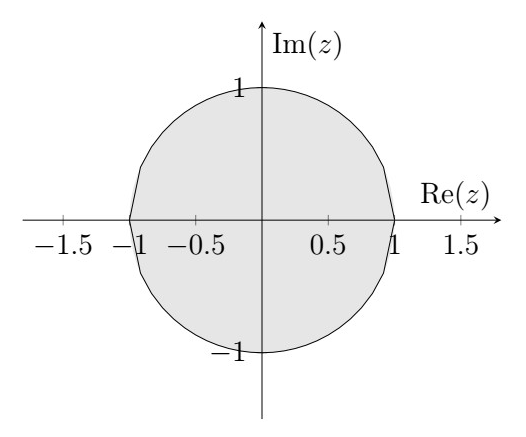

In [10]:

Image(filename="../input/muh-images/unit_roots.png", width= 600, height=200)
 

## Forecasting with ARMA

Let's put our newly introduced framework to the test and actually predict something. We look we will have a look at the quarterly change in the aggregate savings level in the United States - the data is sourced from FRED: https://fred.stlouisfed.org/series/A191RP1Q027SBEA.

<AxesSubplot:xlabel='date'>

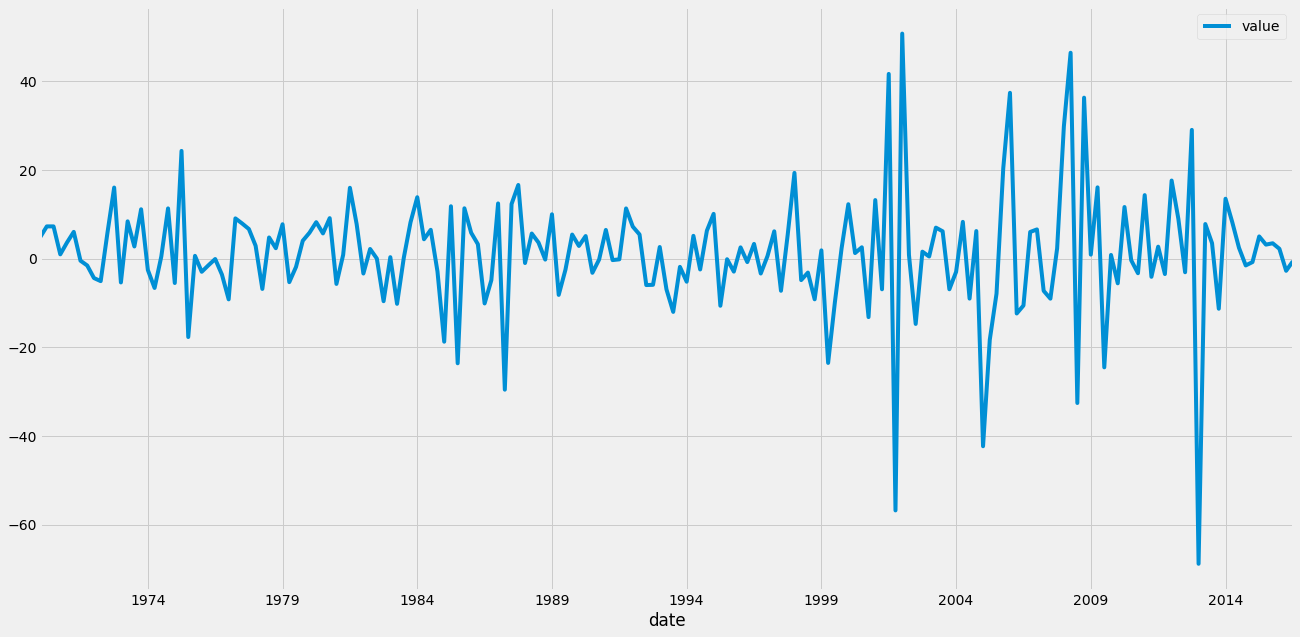

In [11]:
xdat = pd.read_csv(CFG.data_folder + 'savings_change.csv')

xdat.columns = ['date', 'value']
xdat['date'] = pd.to_datetime(xdat['date'])

xdat.set_index('date').plot()

We start with a quick EDA: first, a seasonal decomposition

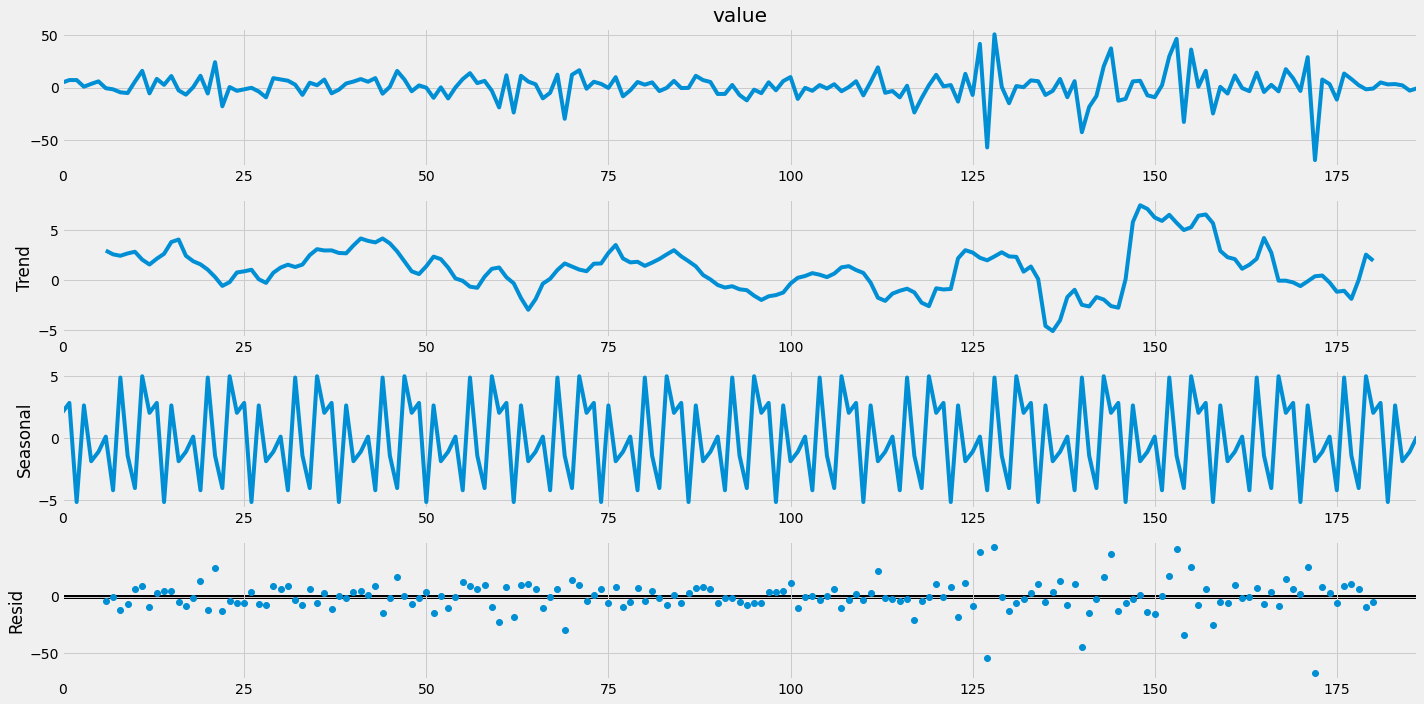

In [12]:
decomposition = sm.tsa.seasonal_decompose(xdat["value"],period =12, model = 'additive') 
figure = decomposition.plot()
plt.show()

There is *a* seasonal component, but it is very small in magnitude; trend does not seem significant either - we can suspect the process is stationary and move to testing this formally (using our old acquaintance, the ADF test):

In [13]:
result = adfuller(xdat['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.705760
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


No red flags stopping us at this stage (reminder: this means we don't see an overall linear trend during the sample period) - we can proceed to model the series as ARMA(p,q). What about the values of p and q?

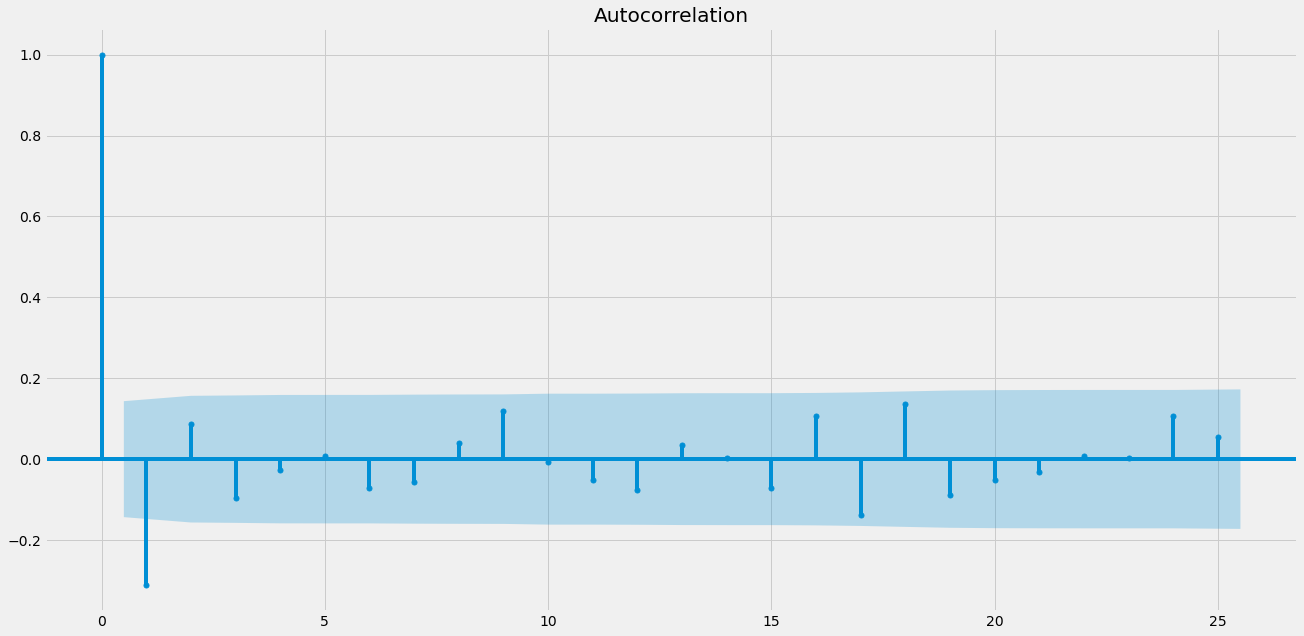

In [14]:
plot_acf(xdat['value'], lags = 25); print()

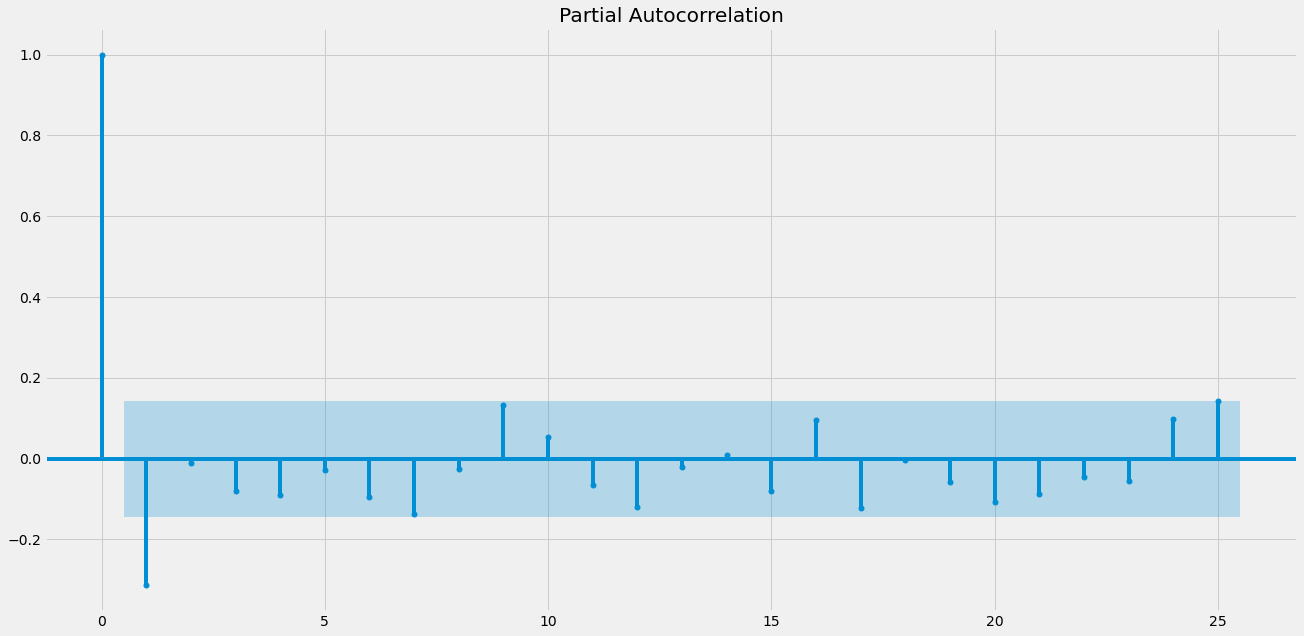

In [15]:
plot_pacf(xdat['value'], lags = 25); print()

At this stage, we could make an educated guess at fitting an ARMA model - (1,0) seems like a reasonable first pass. We can do something better though and use the functionality provided by the `pmdarima` package. Its functionality modernizes the ARIMA functionality from `statsmodels`:
* it allows working with pipelines combining preprocessing and fitting
* enables cross-validation functionality akin to what we saw with`cross_validation` in [Prophet](https://www.kaggle.com/konradb/ts-1b-prophet#Performance-evaluation)
* automates a (somewhat tedious) task of establishing the right order for an ARIMA model

In [16]:
# we split the data into training and validation, leaving out the last 3 years as holdout
xtrain, xvalid = model_selection.train_test_split(xdat['value'], test_size = 12)

One of the useful features of `pmdarima` is a Fourier featurizer:
- it allows us to capture seasonality in the model without worrying about the seasonal order (so use a pure ARIMA with `seasonality = False`) 
- its achieved by creating a set of covariates based on Fourier decomposition
- we can include arbitrary length seasonal pattern
- the short-term dynamics are easily handled with a simple ARMA error

In [17]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1417.652, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1428.604, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1413.626, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1414.732, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1415.564, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1415.511, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1417.401, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1413.240, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1429.318, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1415.233, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1415.223, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1413.866, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1417.096, Time=0.53 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.643 seconds


Pipeline(steps=[('fourier', FourierFeaturizer(m=4)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [18]:
# we can inspect the results
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -699.620
Date:                Fri, 22 Jul 2022   AIC                           1413.240
Time:                        15:37:28   BIC                           1435.394
Sample:                             0   HQIC                          1422.226
                                - 175                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.5503      1.091      1.421      0.155      -0.588       3.689
FOURIER_S4-0     2.2632      1.465      1.545      0.122      -0.609       5.135
FOURIER_C4-0     0.6652      1.497      0.444      0.657      -2.268       3.599
FOURIER_S4-1  9.682e+04   3.97e+05      0.244      0.808   -6.82e+05    8.76e+05
FOURIER_C4-1    -0.0559      4.481     -0.012      0.990      -8.839       8.727
ar.L1           -0.3125      0.043     -7.312      0.000      -0.396      -0.229
sigma2         173.6642     11.068     15.691      0.000     151.972     195.357
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               206.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.35   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Statsmodels provides us with a rich set of descriptive measures characterizing the fitted model:
* the top table summarizes sample size, likelihood and the information criteria - this is helpful if we want to select models on parsimony. For those unfamiliar with the topic, information criteria (AIC, BIC, HQIC ) quantify the basic idea of balancing model complexity (number of parameters) and likelihood, so that we end up selecting a model which has the minimal number of parameters necessary to capture the details of our DGP, but not more than that:https://en.wikipedia.org/wiki/Akaike_information_criterion. An information criterion measures how well a model fits the data while taking into account the overall complexity - model that fits the data very well while using large number of parameters will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. 

* the middle table gives the estimated coefficients of the model: $ar.L_{i}$ corresponds to the coefficient of the AR part at lag $i$, which $sigma2$ is the variance of the noise component. The $Z$ statistic and the endpoints of a confidence interval allow for a quick assessment of statistical significance

* finally, the box at the bottom summarizes some diagnostic test: Jarque-Bera is used for testing if the residuals of the model have Gaussian distribution, while Ljung-Box checks whether the results are serially independent. In our case the former shows no problem, while L-B indicates there is some serial dependence in the residuals of our model, so there mighte be some component of the dynamics we are not capturing. 

In [19]:
# we compute predictions from the pipeline object
preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)
print("\nForecasts:")
print(preds)



Forecasts:
[ 1.40469033  2.58813689  1.78353876 -2.48403119  3.29628499  1.97367987
  1.9988512  -2.57459931  3.34786715  1.93428243  2.03444012 -2.60899838]


In [20]:
print("\nConfidence intervals:")
print(conf_int)



Confidence intervals:
[[-24.4240525   27.23343316]
 [-24.47263541  29.64890919]
 [-25.39457838  28.96165591]
 [-29.67358287  24.70552049]
 [-23.8943833   30.48695328]
 [-25.21709748  29.16445722]
 [-25.1919368   29.18963921]
 [-29.76538835  24.61618974]
 [-23.84292199  30.5386563 ]
 [-25.25650673  29.12507159]
 [-25.15634904  29.22522928]
 [-29.79978754  24.58179077]]


Unlike the uncertainty bands for Prophet (which are calculated non-parametrically by resampling the data with MCMC), ARMA confidence intervals are based on a parametric approach:
* we assume the residual terms $\epsilon_t$ have Gaussian distribution
* Gaussian is closed under addition $\implies$ $X_t$ is Gaussian
* Hilbert projection theorem $\implies$ expected value is our best forecast wrt MSE
* confidence interval for the mean: $\mu_t \pm 1.96 \; \sigma_t$ with
\begin{equation}
\mu_t = E\left[X_t | \sigma(X_t) \right]
\end{equation}
and
\begin{equation}
\sigma^2_t = Var\left[X_t | \sigma(X_t) \right]
\end{equation}

In [21]:
xvalid

175   -11.276615
176    13.520202
177     8.244048
178     2.461953
179    -1.513050
180    -0.758400
181     5.023918
182     3.180930
183     3.482786
184     2.236534
185    -2.721501
186    -0.572858
Name: value, dtype: float64

<AxesSubplot:>

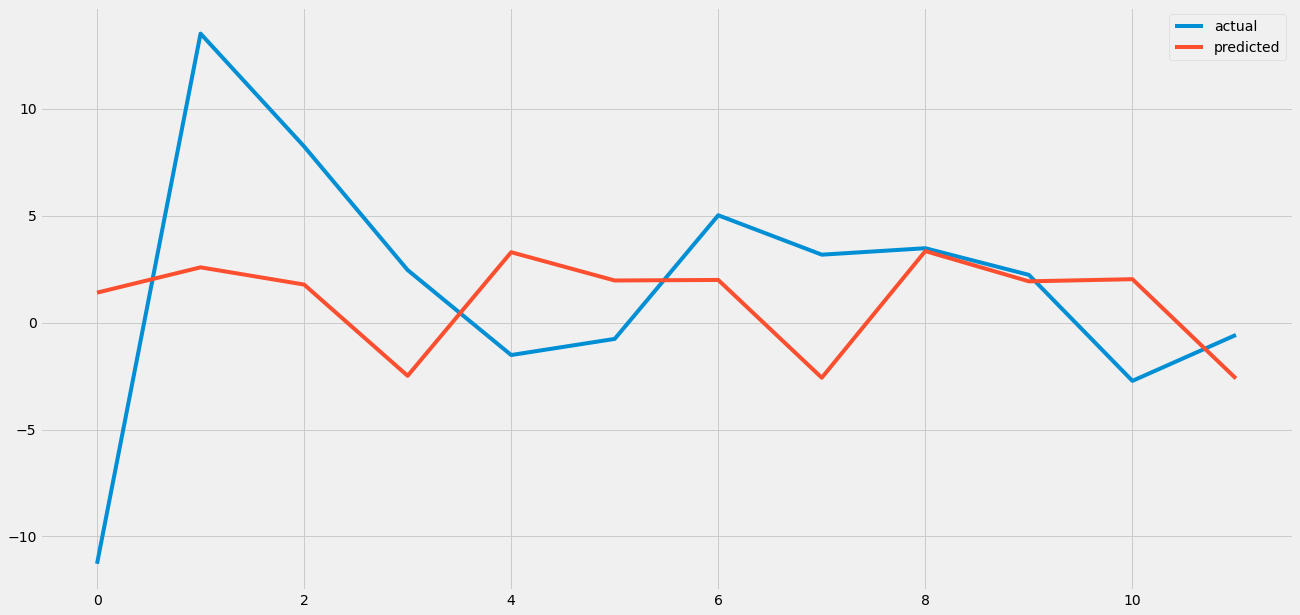

In [22]:
# let's quickly visualize the forecast
xvalid = pd.DataFrame(xvalid.values, columns = ['actual'])
xvalid['predicted'] = preds
xvalid.plot()

In terms of forecast quality this model can be useful as a baseline, but overall it is clearly nothing to write home about:
1. there is a predictable lag: one period after an increase in the original series the forecast goes up as well; this is due to autoregressive nature of the model
2. the model captures the general dynamics of the model, but struggles with the range of values - this is a consequence of the constant variance assumption

<a id="section-two"></a>
# Beyond ARMA

As we can see from the examples above, there are issues when applying the baseline $ARMA(p,q)$ model to real life time series:
* the models are only efficient if the series is stationary - peformance deteriorates rapidly otherwise 
* does not allow for trend
* does not allow for seasonality

The last two issues can be handled by differencing the series at appropriate lags, and it is this idea that allows us to extend ARMA - first, we move towards ARIMA. 

### ARIMA

A process $X_t$ is ARIMA(p,d,q) $\iff$ $\nabla^d X_t$ is a stationary ARMA(p,q)

Unpacking the (slightly cryptic :-) formulation: 
* a series becomes a stationary ARMA(p,q) after differencing it $d$ times

* differencing is a discrete version of differentiation: polynomial of order $d$ becomes a constant after taking $d$th derivative $\implies$ a series stationary around a linear trend becomes stationary in first differences (quadratic trend - second differences etc)



<AxesSubplot:xlabel='date'>

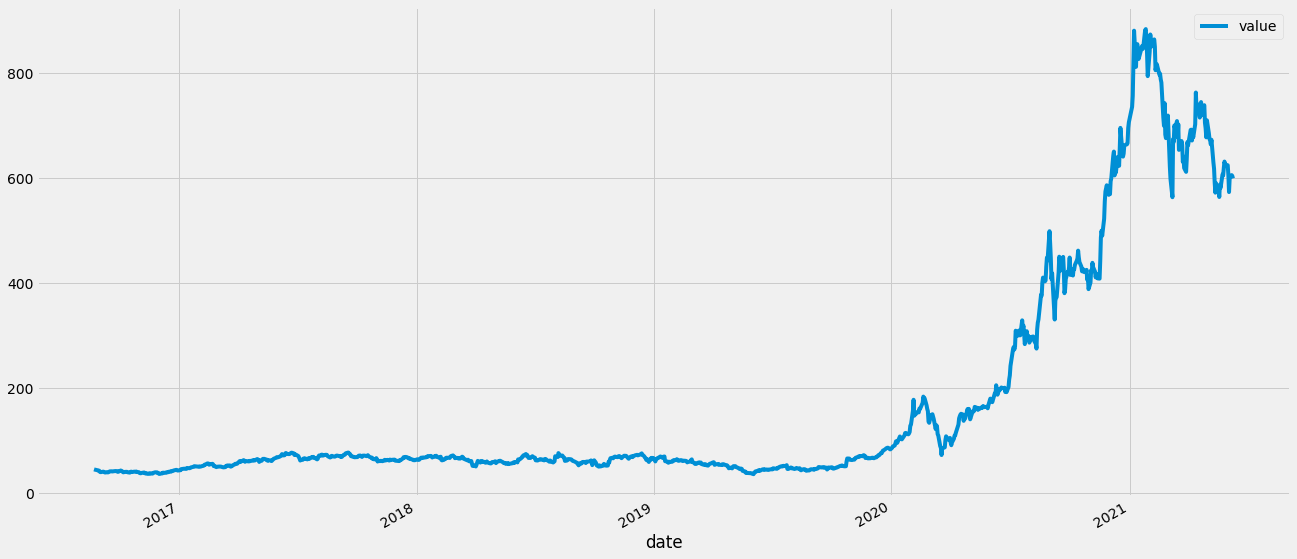

In [23]:
# quick demo: Tesla daily closing price on NYSE 
xdat = pd.read_csv(CFG.data_folder + 'tesla_prices_5y.csv', usecols = ['Date', 'Close'])
xdat.columns = ['date', 'value']

# xdat['value'] = np.log1p(xdat['value'])
xdat['date'] = pd.to_datetime(xdat['date'])
xdat.set_index('date').plot()

Applying Dickey-Fuller test confirms that the series certainly is not stationary:

In [24]:
result = adfuller(xdat['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.223000
p-value: 0.935724


With apologies for the pun, applying `.diff()` operator makes all the difference:

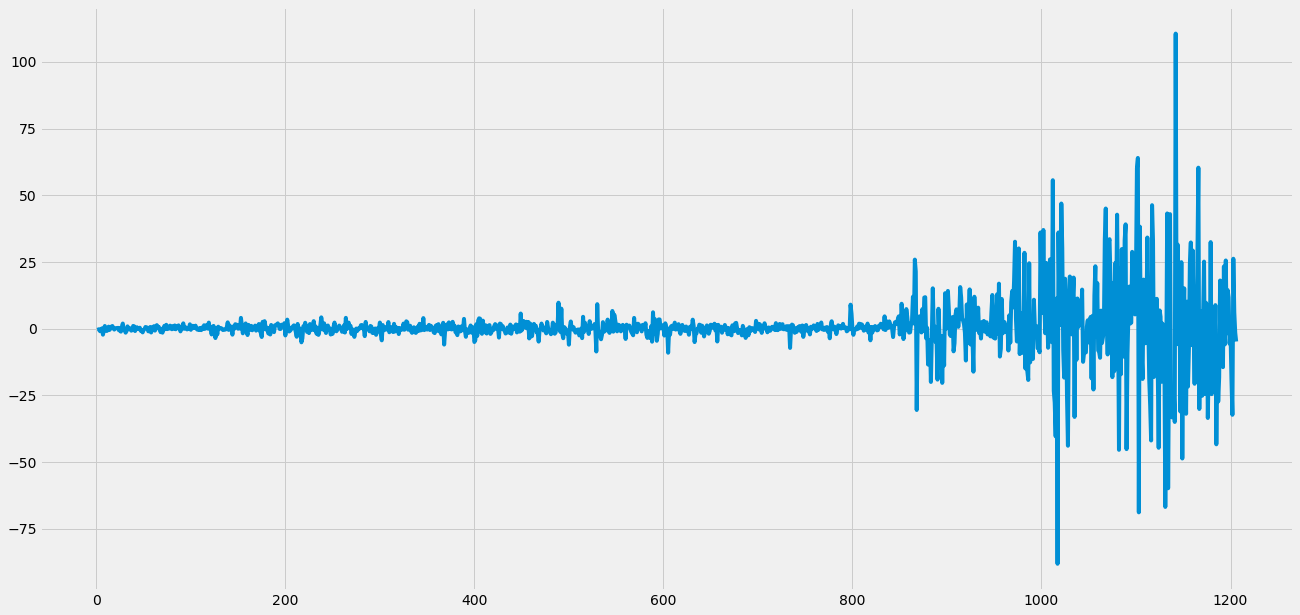

In [25]:
ydat = xdat['value'].diff()
ydat.plot()
print()

In [26]:
result = adfuller(ydat.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.940299
p-value: 0.000000


As you can see, differencing the time series once removes a linear trend and produces a series for which the null is not rejected in Dickey-Fuller test - this is despite the fact the volatility clearly goes up in the latter part of the sample!

The basic idea is that if we are dealing with a series that can be represented as a stationary process with polynomial trend, we can model it jointly (instead of manually differencing $d$ times and then flipping back). 


Sideline point worth mentioning is that a non-seasonal ARIMA encapsulates other models as special cases (to quote a line from several textbooks I used in university: verifying those assertions is left as an exercise to the reader ;-)

- ARIMA(0,0,0) is white noise
- ARIMA(0,1,0) is random walk
- ARIMA(p,0,0) is AR(p)
- ARIMA(0,0,q) is MA(q)
- ARIMA(0, 1, 1) is equivalent to single (basic) exponential smoothing model
- ARIMA(0, 2, 2) is equivalent to Holt's linear method with additive errors, i.e. [double exponential smoothing](https://www.kaggle.com/konradb/ts-1a-smoothing-methods#Popular-methods)


### SARIMA

The "I" in ARIMA corresponds to the "integrated" component, which is a formal way of saying we are incorporating the trend into our setup starting with a stationary $ARMA(p,q)$ process. Following a similar logic, we can incorporate the seasonal component and allow it to follow the same type of dynamic: a seasonal ARIMA (SARIMA) model can be denoted as ARIMA(p,d,q)(P,D,Q)m, where:
- m refers to the number of periods in each season
- (lowercase) p,d,q refer to the definition of the ARIMA part
- (uppercase) P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model.



The last part is not entirely obvious at an intuitive model (at least it wasn't to me when I learned it). A good intuition to think about is that we want to identify components of the seasonal part the way we would for the series itself:
* we isolate the seasonal component, e.g. through seasonal decomposition
* to establish the value of $D$ we test the seasonal component - is it stationary? is the differenced version stationary? 
* the seasonal autoregressive value $P$ can be established by inspecting the PACF of the seasonal component
* the seasonal moving average value $Q$ can be established by inspect the ACF of the seasonal component

Below, we demonstrate briefly how this analysis can be conducted in practice:

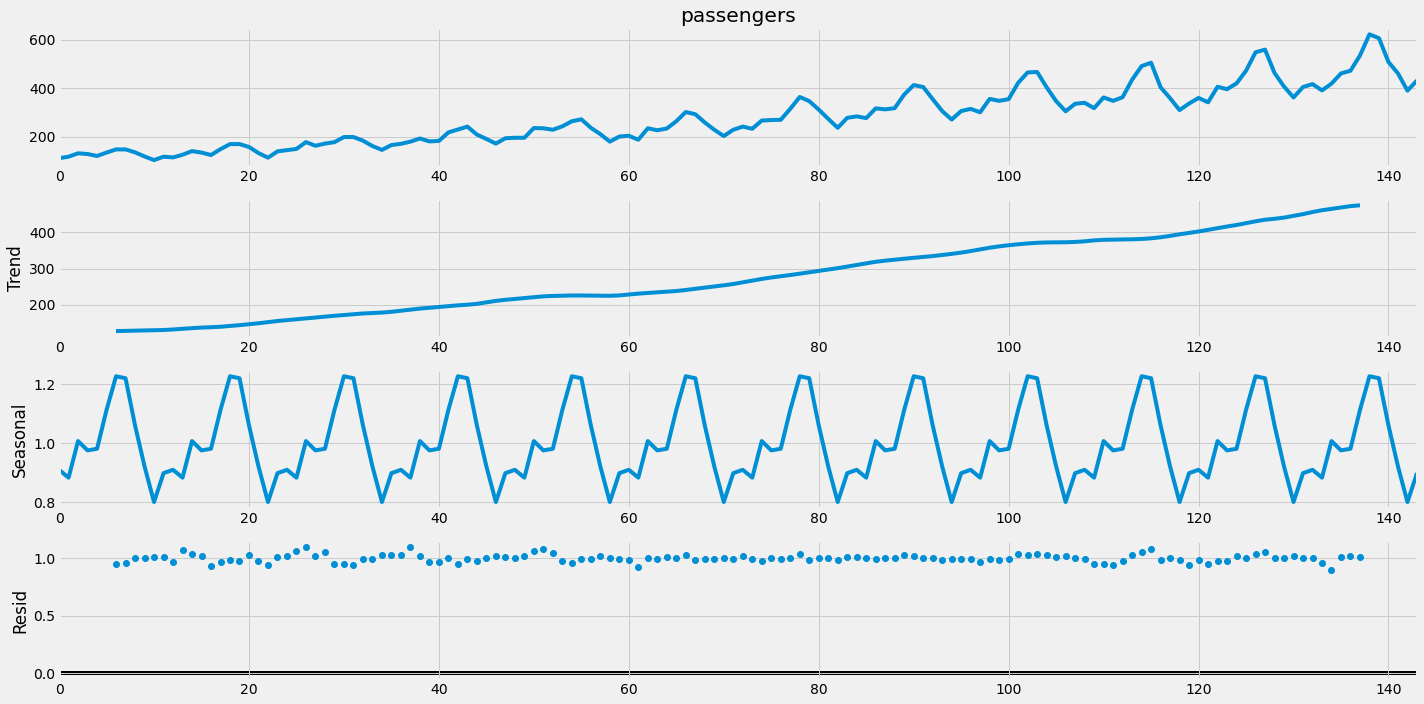

In [27]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])


decomposition = seasonal_decompose(series['passengers'], period = 12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

In [28]:
# check stationarity
result = adfuller(decomposition.seasonal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2429382252176873.500000
p-value: 0.000000


Non-stationarity is rejected extremely strongly, do $D$ = 0 in our example. What about the other components?

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


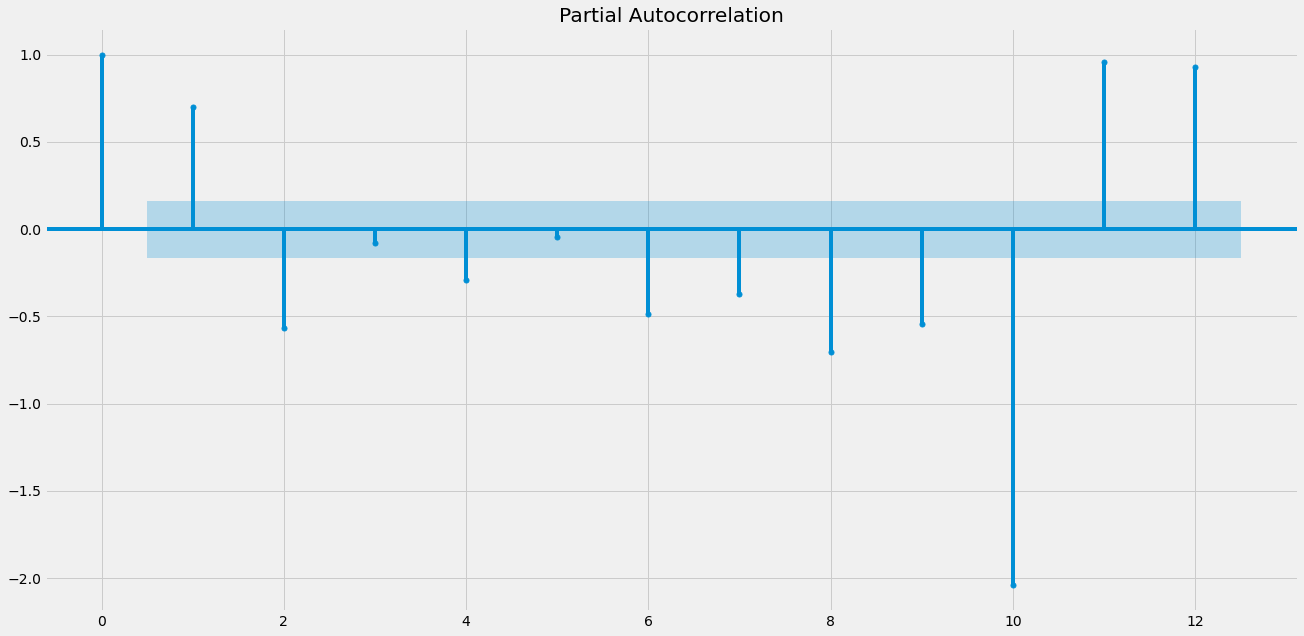

In [29]:
plot_pacf(decomposition.seasonal, lags = 12); print()

Relevant PACF values up until lag 12 at least indicate $P$ = 1 is the right choice.

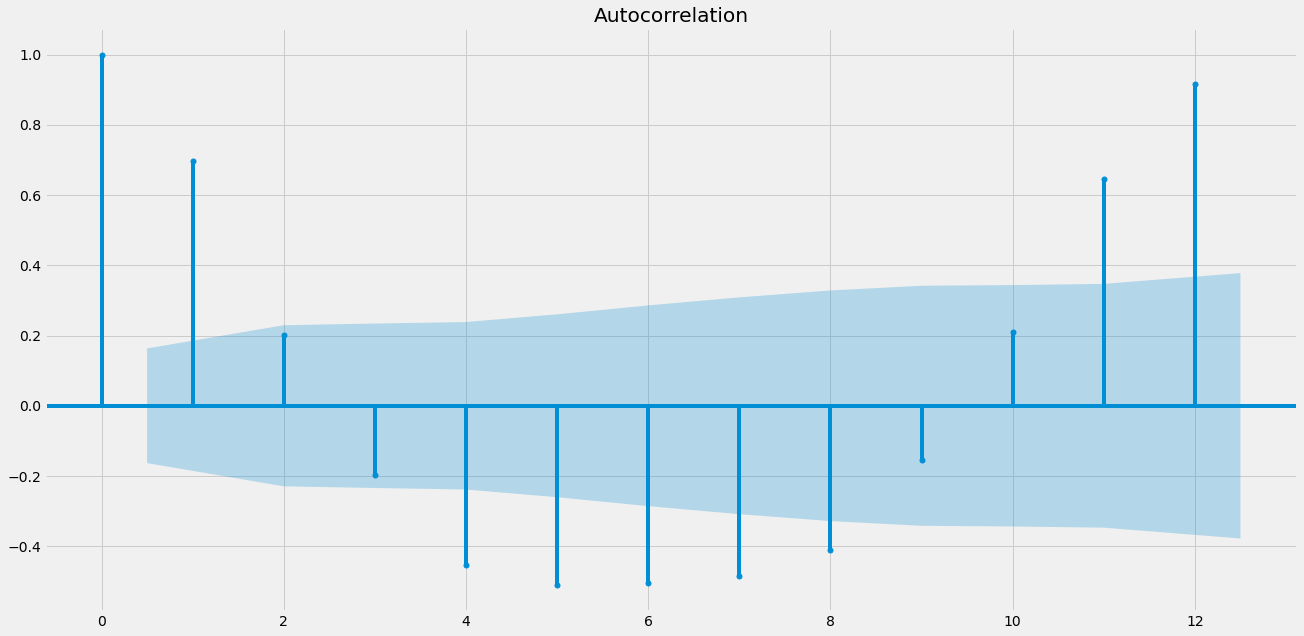

In [30]:
plot_acf(decomposition.seasonal, lags = 12); print()

Based on the ACF graph above $Q=1$ seems like a reasonable choice.


For the more mathematically members of the audience, the SARIMA model can be formulated quite compactly if we make use of the backshift (lag) operator (https://en.wikipedia.org/wiki/Lag_operator).  The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period. For example, an $ARIMA(1,1,1)(1,1,1)_4$ model for quarterly data (m = 4) series $y_t$ can be specified as 

\begin{equation}       
    (1 - \phi_1 B)(1- \Phi_1 B^4)(1- B)(1-B^4)y_t = (1 + \theta_1 B)(1 + \Theta_1 B)\epsilon_t
\end{equation}

### SARIMAX

Sometimes we do have data available for the forecast horizon (e.g. long term economic forecasts available in advance, or the lagged values of the series itself). This means we can use **exogenous** variables to improve the quality of the forecast - hence SARIMA**X**.

<a id="section-three"></a>
# Full pipeline

We are in a position to combine all the building blocks and solve a real-life problem in full generality. We will use the data from the Demand Forecasting competition: 
https://www.kaggle.com/c/demand-forecasting-kernels-only

In [31]:
# load the data
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)

In [32]:
# we subset to one item x store combination
buf = df[(df.item==1)&(df.store==1)].copy()
buf.head(10)

,id,item,sales,store
date,,,,
2013-01-01,NaN,1,13.0,1
2013-01-02,NaN,1,11.0,1
2013-01-03,NaN,1,14.0,1
2013-01-04,NaN,1,13.0,1
2013-01-05,NaN,1,10.0,1
2013-01-06,NaN,1,12.0,1
2013-01-07,NaN,1,10.0,1
2013-01-08,NaN,1,9.0,1
2013-01-09,NaN,1,12.0,1


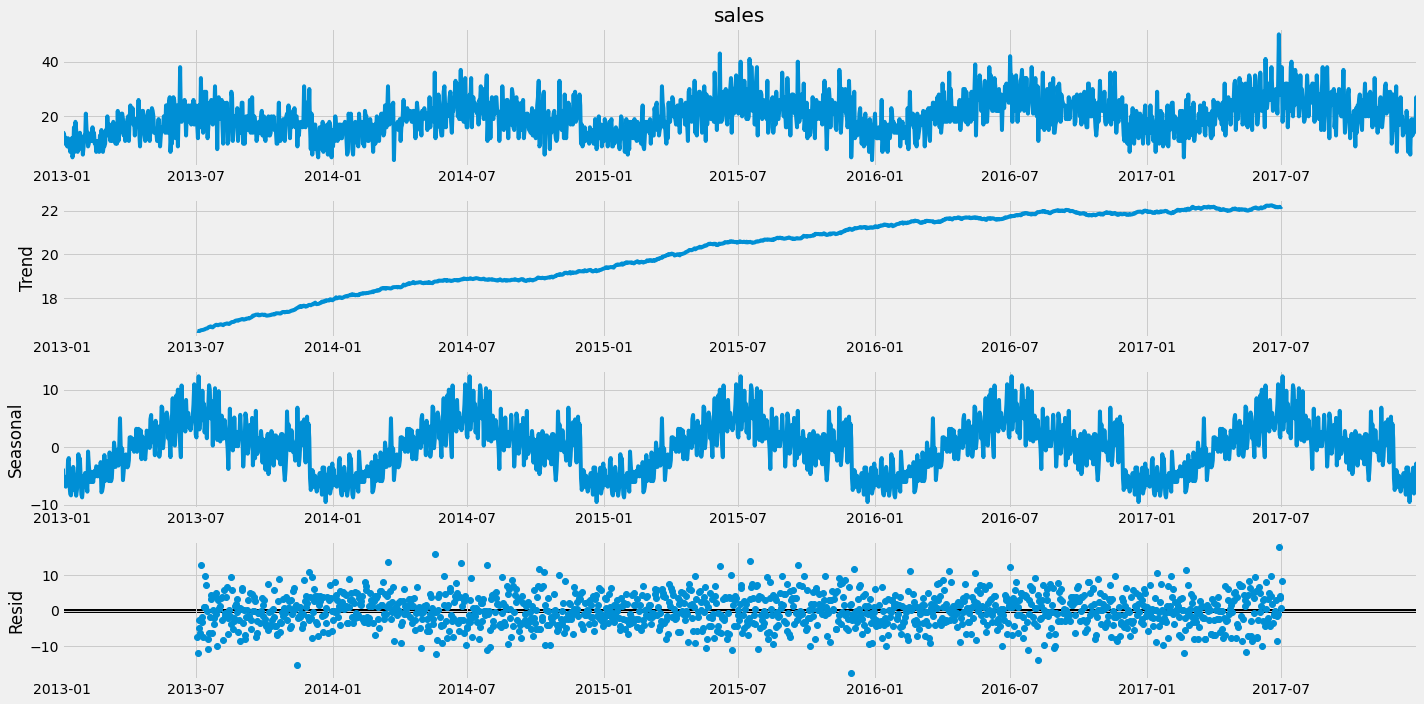

In [33]:
# what do the components look like? 
decomposition = seasonal_decompose(buf.sales.dropna(),freq=365)
figure = decomposition.plot()
plt.show()

With four years worth of data, we can think about capturing seasonal patterns (always worth remembering: modeling seasonal effects makes sense if you have at least two complete data cycles in your dataset). We begin by splitting into training and test:

In [34]:
tr_start,tr_end = '2014-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
x0 = buf['sales'][tr_start:tr_end].dropna()
x1 = buf['sales'][te_start:te_end].dropna()

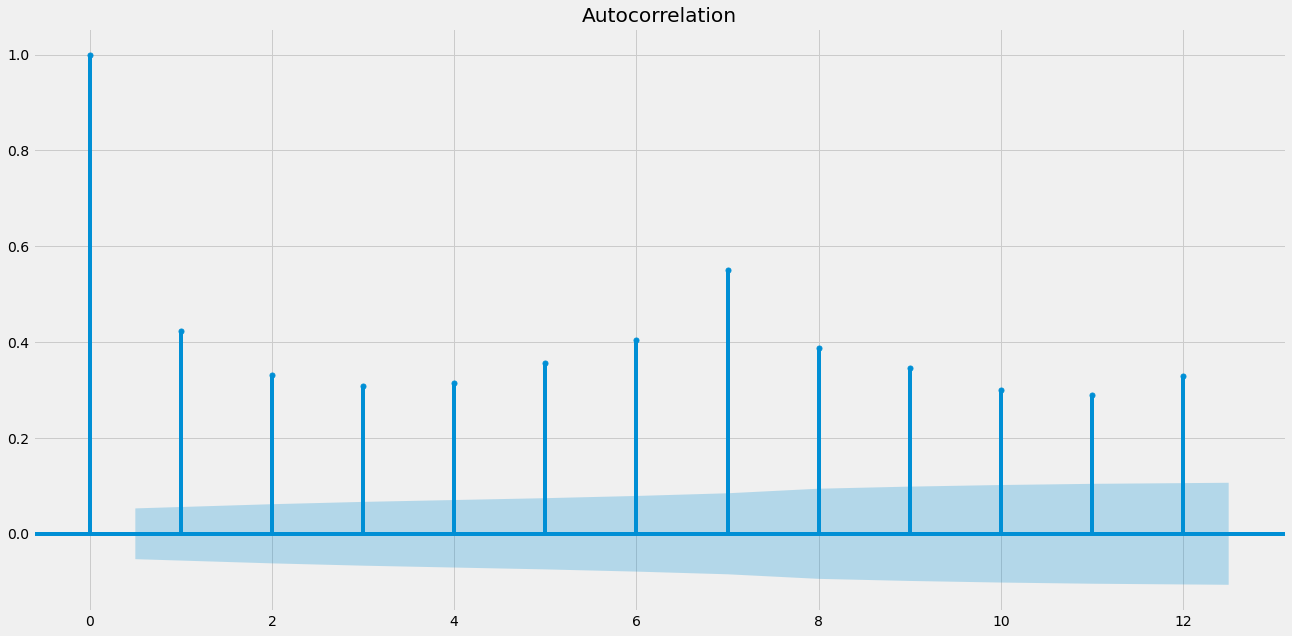

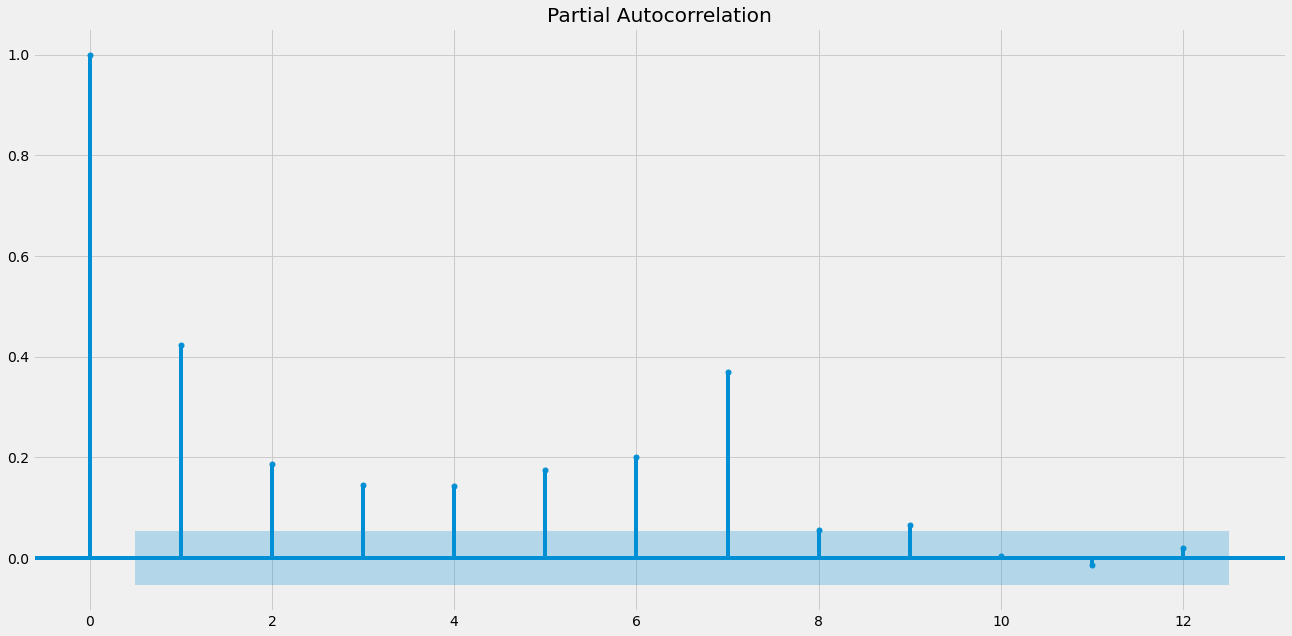

In [35]:
# examine autocorrelation
plot_acf(x0, lags = 12); print()
plot_pacf(x0, lags = 12); print()

Indeed it does. We will conduct a quick grid search across possible values for the model order coefficients. 

In [36]:
model_autoARIMA = auto_arima(x0, start_p=7, start_q=7 ,
                      test='adf',       
                      max_p= 7, max_q=7, 
                      m= 7,              
                      d= 1,
                      seasonal=True,   
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)




Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,1,1)[7]             : AIC=inf, Time=12.31 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9783.794, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=9076.573, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=9482.428, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=8942.628, Time=0.53 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.36 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=9292.960, Time=0.35 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=8771.023, Time=0.67 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=8902.831, Time=0.35 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.14 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.50 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=8677.203, Time=0.70 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=8810.188, Time=0.42 

In [37]:
print(model_autoARIMA.summary())


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1369
Model:             SARIMAX(6, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -4277.811
Date:                           Fri, 22 Jul 2022   AIC                           8573.621
Time:                                   15:39:24   BIC                           8620.565
Sample:                                        0   HQIC                          8591.194
                                          - 1369                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8487      0.028    -30.292      0.000      -0.904      -0.794
ar.L2         -0.7342      0.036    -20.322

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


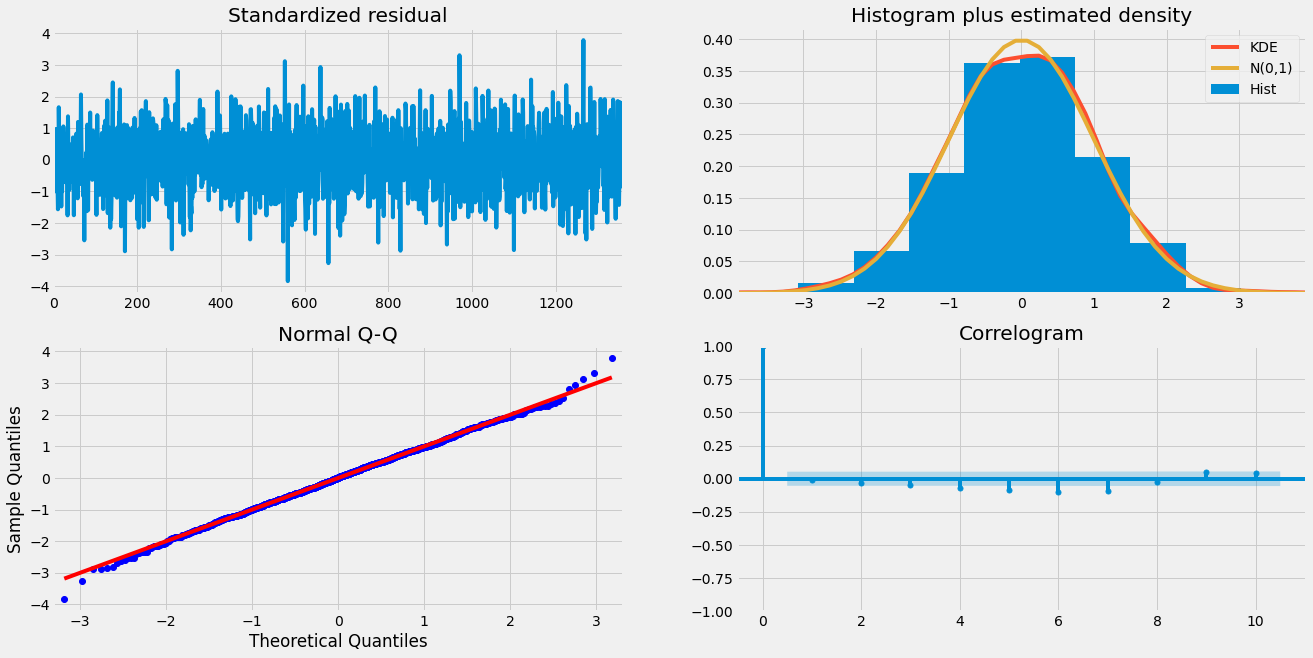

In [38]:
model_autoARIMA.plot_diagnostics()
plt.show()

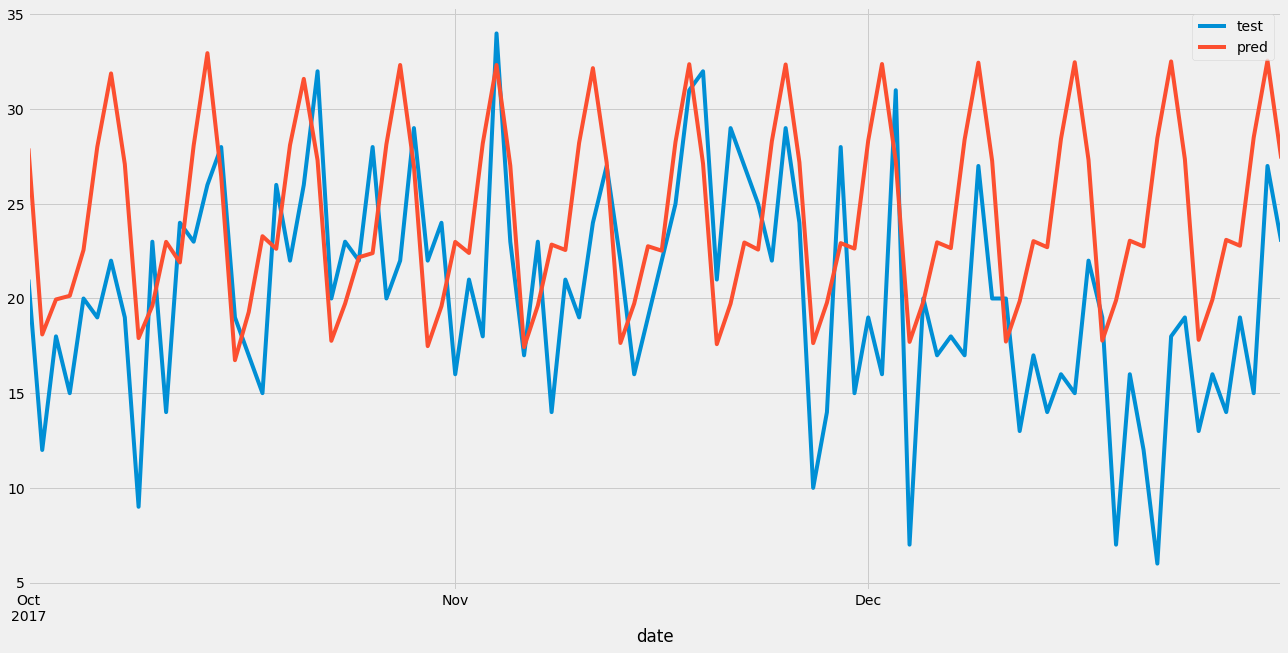

In [39]:
pred = model_autoARIMA.predict(x1.shape[0])

pd.DataFrame({'test':x1,'pred':pred}).plot();plt.show()

As you can see from the graph above (and the diagnostics summary that preceded it), automatically fitted SARIMA does a decent job at capturing the dynamics of the underlying process - but there are still issues with capturing the range of values, with the most likely reasons being time-varying variance or distribution asymmetry. 


Let's compare its performance against [Prophet](https://www.kaggle.com/konradb/ts-1b-prophet).

<a id="section-four"></a>
# A day at the races

We will be using data from the Nifty-50 index, which is an aggregate for the National Stock Exchange in India (an updated dataset is maintained courtesy of [Rohan](https://www.kaggle.com/rohanrao)): https://www.kaggle.com/rohanrao/nifty50-stock-market-data. Both models will be fitted with default settings, without incorporating special days and the like.

In [40]:
stock_name = 'TATASTEEL'

# load the data
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv')
df.set_index("Date", drop=False, inplace=True)

df.head(5)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,TISCO,EQ,142.35,148.00,153.2,146.10,152.50,152.45,150.92,2003185,3.023164e+13,NaN,NaN,NaN
2000-01-04,2000-01-04,TISCO,EQ,152.45,150.10,153.0,143.05,151.95,150.80,151.03,1555136,2.348785e+13,NaN,NaN,NaN
2000-01-05,2000-01-05,TISCO,EQ,150.80,144.60,162.9,144.60,158.00,156.55,156.85,3840284,6.023364e+13,NaN,NaN,NaN
2000-01-06,2000-01-06,TISCO,EQ,156.55,158.95,169.1,158.95,169.00,168.25,167.61,2560449,4.291530e+13,NaN,NaN,NaN
2000-01-07,2000-01-07,TISCO,EQ,168.25,173.40,179.0,166.30,170.55,171.95,173.89,3641691,6.332459e+13,NaN,NaN,NaN


<AxesSubplot:xlabel='Date'>

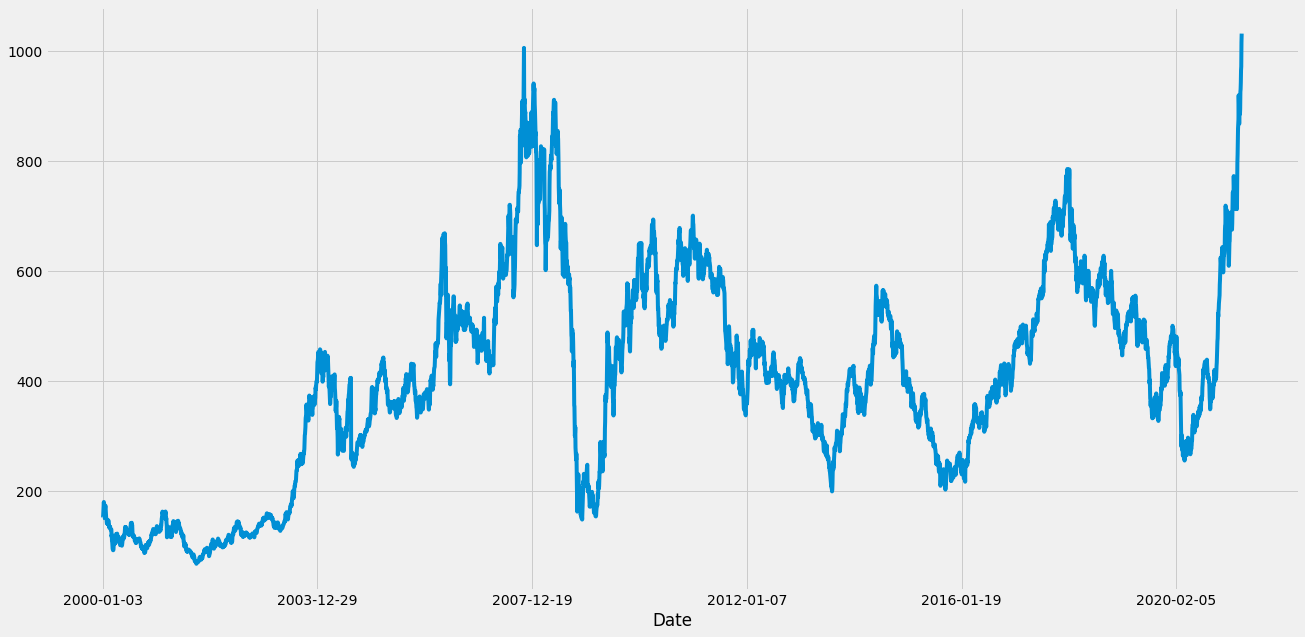

In [41]:
# plot the target 
df.VWAP.plot()

In [42]:
# we can construct some simple features to be used as explanatory variables: 
# rolling statistics over the last 3 days for the price and volume characteristics

lag_features = ["High", "Low", "Volume"]
window_size = 3

df_rolled = df[lag_features].rolling(window = window_size, min_periods=0)
df_mean = df_rolled.mean().shift(1).reset_index()
df_std = df_rolled.std().shift(1).reset_index()

for feature in lag_features:
    df[feature + '_mean_lag' + str(window_size)] = df_mean[feature].values
    df[feature + '_std_lag' + str(window_size)] = df_std[feature].values

# Prophet can handle missing values, but ARIMA cannot
df.fillna(df.mean(), inplace=True)

In [43]:
# prepare the training / validation split
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ['High_mean_lag3', 'High_std_lag3', 'Low_mean_lag3',
       'Low_std_lag3', 'Volume_mean_lag3', 'Volume_std_lag3',]

In [44]:
# fit ARIMA in the same manner as before 
model_arima = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], 
                   m = 7,  
                   # max ranges for the p,q,P,Q parameters - can be extended
                   max_p= 2, max_q=2,    
                   max_P = 1, max_Q = 1,
                   trace=True, error_action="ignore", suppress_warnings=True)
model_arima.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model_arima.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=35921.269, Time=41.21 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=38986.123, Time=5.21 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=36339.065, Time=22.76 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=38867.406, Time=24.74 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=74270.674, Time=4.69 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=35919.583, Time=37.48 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=35920.888, Time=25.55 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=35919.194, Time=33.00 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=35915.836, Time=26.98 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=35917.349, Time=23.42 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=35917.847, Time=36.52 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=35916.140, Time=33.26 sec
 ARIMA(0,0,2)(1,0,0)[7] intercept   : AIC=36040.051, Time=27.56 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=36045.303, Time=25.13 sec
 ARIMA(

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [45]:
# fit a Prophet model with default parameters

df = df_train[['Date', 'VWAP']].rename(columns={"Date": "ds", "VWAP": "y"})

model_prophet = Prophet()

# add the regressors to the dataframe holding the data
for f in exogenous_features:    
    df[f] = df_train[f]
    model_prophet.add_regressor(f)

# the rest proceeds as before. 
model_prophet.fit(df)

In [46]:
forecast = model_prophet.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values


<AxesSubplot:xlabel='Date'>

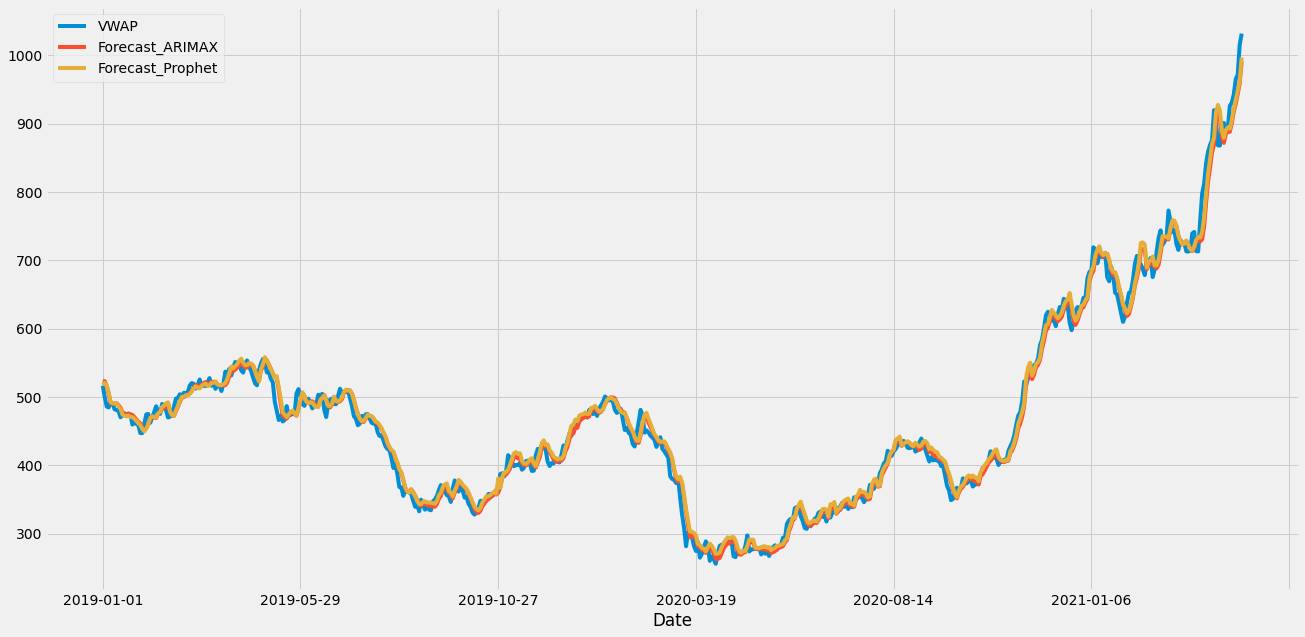

In [47]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot()


In [48]:
def friendly_rmse(x,y):
    return np.round(np.sqrt(mean_squared_error(x, y))  ,4)

print("RMSE of Auto ARIMAX:", friendly_rmse(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("RMSE of Prophet:", friendly_rmse(df_valid.VWAP, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX: 15.4719
RMSE of Prophet: 15.3825


As we can see from this small comparison, a vintage method like SARIMAX achieves comparable performance with a modern solution like Prophet. While it takes a bit more effort to set up, a full probabilistic model allows for more detailed and informative inference.

